In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images 
from sklearn import datasets
from sklearn.datasets import fetch_lfw_people



## PCA

In [72]:
class PCA:
    def __init__(self, n_components, num_iterations=100):
        self.n_components = n_components
        self.num_iterations = num_iterations 
        self.mean = None
        self.components = None  
        self.eigenvalues = None

    def _calculate_mean(self, X):
        return np.sum(X, axis=0) / X.shape[0]

    def _calculate_covariance(self, X_centered):
        n_samples = X_centered.shape[0]
        return np.dot(X_centered.T, X_centered) / (n_samples - 1)

    def _power_iteration(self, C):

        n_features = C.shape[0]
        v = np.random.rand(n_features)
        v = v / np.sqrt(np.sum(v**2))  

        for _ in range(self.num_iterations):
            Cv = np.dot(C, v)
            
            norm = np.sqrt(np.sum(Cv**2))
            v = Cv / norm
        
        eigenvalue = np.dot(v.T, np.dot(C, v))
        
        return eigenvalue, v

    def fit(self, X):
        n_samples, n_features = X.shape

        self.mean = self._calculate_mean(X)
        X_centered = X - self.mean

        covariance_matrix = self._calculate_covariance(X_centered)

        C_copy = np.copy(covariance_matrix)

        self.components = np.zeros((n_features, self.n_components))
        self.eigenvalues = np.zeros(self.n_components)

        for i in range(self.n_components):

            eigenvalue, eigenvector = self._power_iteration(C_copy)
            
            # Store them
            self.eigenvalues[i] = eigenvalue
            self.components[:, i] = eigenvector
            
            C_copy = C_copy - eigenvalue * np.outer(eigenvector, eigenvector)

    def transform(self, X):

        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X_compressed):
        X_reconstructed_centered = np.dot(X_compressed, self.components.T)
        X_reconstructed = X_reconstructed_centered + self.mean
        return X_reconstructed

Original grayscale image shape: (50, 37)
Compressed gray data shape: (50, 6)
Decompressed gray image shape: (50, 37)


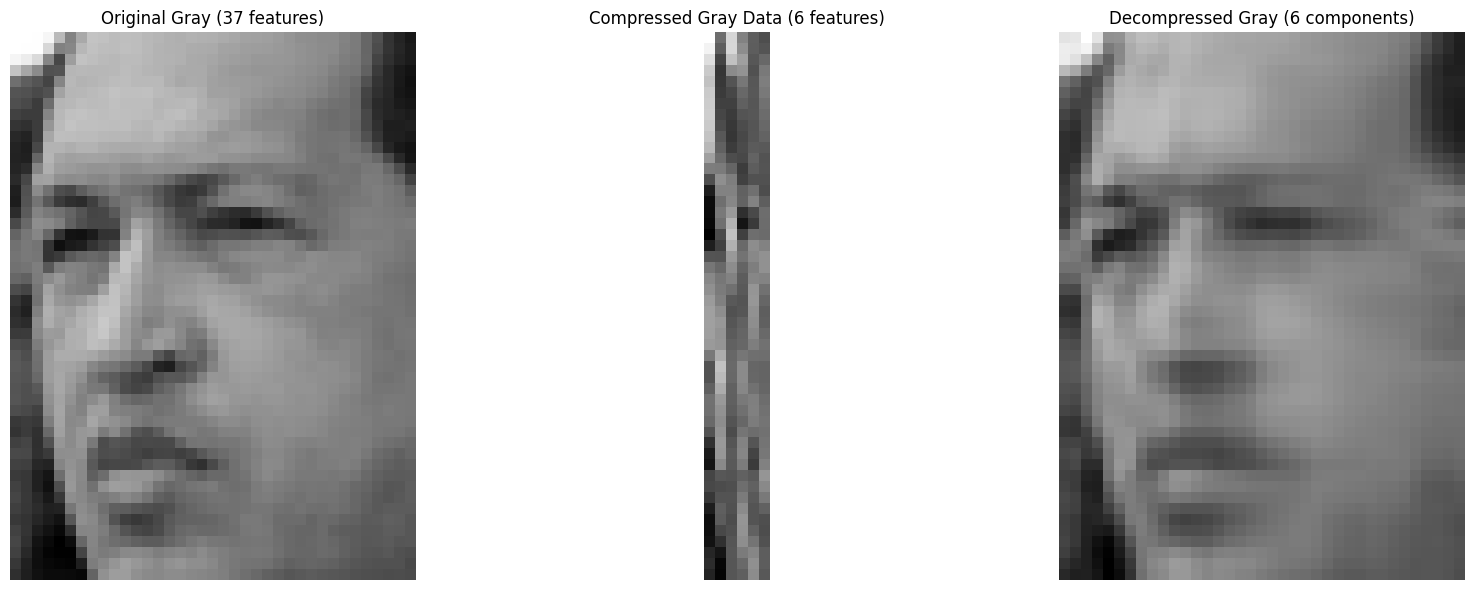

Original gray data points: 1850
Compressed gray representation points: 559
Gray compression ratio: 3.31 : 1


In [73]:
img_gray = img_gray_original / 255.0  
height_gray, width_gray = img_gray.shape

print(f"Original grayscale image shape: {img_gray.shape}")

n_components_gray = 6
n_channels_gray = 1  

pca_gray = PCA(n_components=n_components_gray)

img_gray_compressed = pca_gray.fit_transform(img_gray)
img_gray_decompressed = pca_gray.inverse_transform(img_gray_compressed)
img_gray_compressed_display = scale_for_display(img_gray_compressed)
img_gray_decompressed_clipped = np.clip(img_gray_decompressed, 0, 1)

print(f"Compressed gray data shape: {img_gray_compressed.shape}")
print(f"Decompressed gray image shape: {img_gray_decompressed.shape}")

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(img_gray, cmap='gray')
ax[0].set_title(f"Original Gray ({width_gray} features)")
ax[0].axis('off')

ax[1].imshow(img_gray_compressed_display, cmap='gray')
ax[1].set_title(f"Compressed Gray Data ({n_components_gray} features)")
ax[1].axis('off')

ax[2].imshow(img_gray_decompressed_clipped, cmap='gray')
ax[2].set_title(f"Decompressed Gray ({n_components_gray} components)")
ax[2].axis('off')

plt.tight_layout()
plt.show()

original_size_gray = height_gray * width_gray

compressed_size_gray = (height_gray * n_components_gray) + (width_gray * n_components_gray) + width_gray

print(f"Original gray data points: {original_size_gray}")
print(f"Compressed gray representation points: {compressed_size_gray}")
print(f"Gray compression ratio: {original_size_gray / compressed_size_gray:.2f} : 1")

## Bonus 1

Original image shape: (427, 640, 3)
Compressed data shape: (427, 64, 3)
Decompressed image shape: (427, 640, 3)


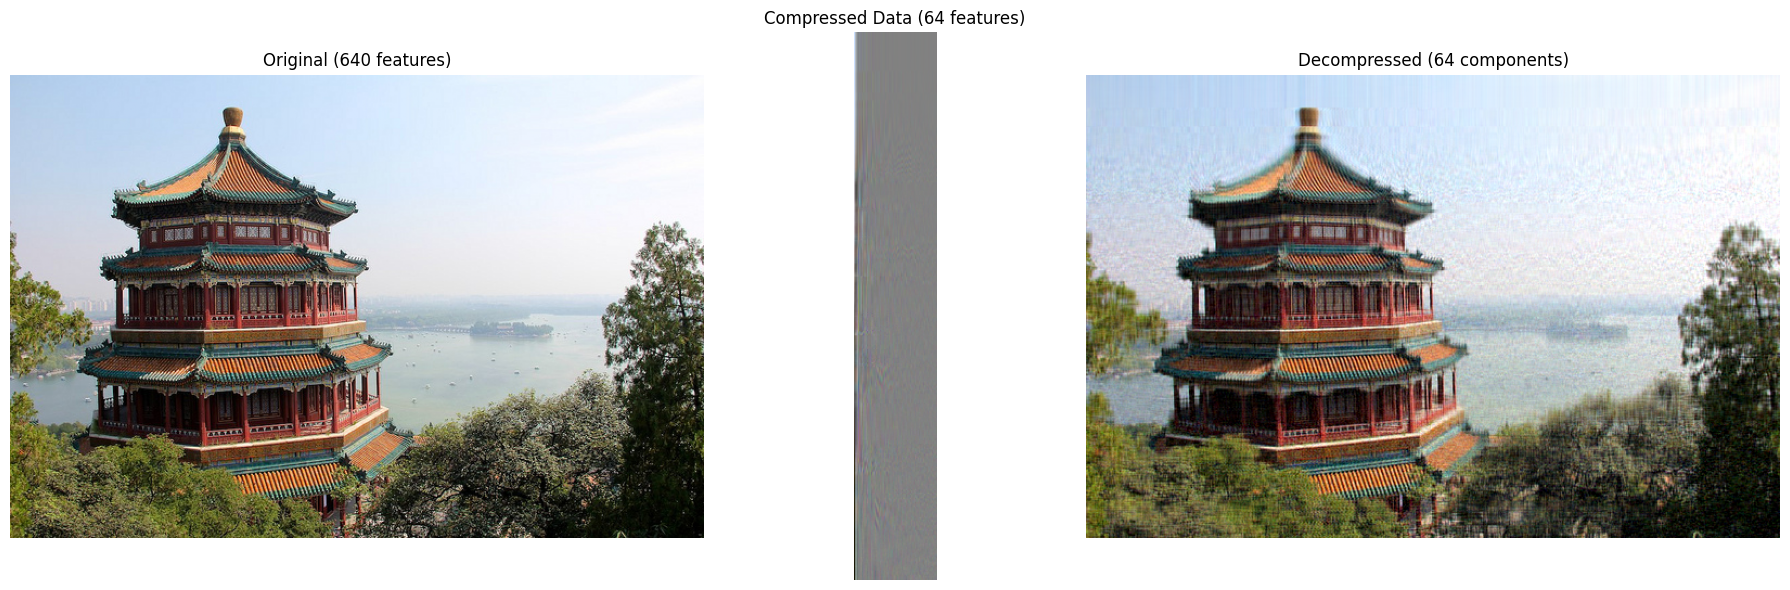

Original data points: 819840
Compressed representation points (approx): 206145
Compression ratio (approx): 3.98 : 1


In [74]:
def scale_for_display(image):
    
    img_min = image.min()
    img_max = image.max()
    if img_max == img_min:
        return np.zeros_like(image)
    return (image - img_min) / (img_max - img_min)

images = load_sample_images()
img_original = images.images[0]  

img = img_original / 255.0

height, width, n_channels = img.shape
print(f"Original image shape: {img.shape}")


n_components = 64

channels_compressed = []
channels_decompressed = []
pca_models = []

for i in range(n_channels):
    channel_data = img[:, :, i]
    
    pca = PCA(n_components=n_components)
    
    channel_compressed = pca.fit_transform(channel_data)
    channels_compressed.append(channel_compressed)
    
    channel_decompressed = pca.inverse_transform(channel_compressed)
    channels_decompressed.append(channel_decompressed)
    
   
    pca_models.append(pca)



img_compressed_data = np.stack(channels_compressed, axis=-1)
img_compressed_display = scale_for_display(img_compressed_data)


img_decompressed = np.stack(channels_decompressed, axis=-1)

img_decompressed_clipped = np.clip(img_decompressed, 0, 1)



print(f"Compressed data shape: {img_compressed_data.shape}")
print(f"Decompressed image shape: {img_decompressed.shape}")

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(img)
ax[0].set_title(f"Original ({width} features)")
ax[0].axis('off')

# 
ax[1].imshow(img_compressed_display)
ax[1].set_title(f"Compressed Data ({n_components} features)")
ax[1].axis('off')

# 
ax[2].imshow(img_decompressed_clipped)
ax[2].set_title(f"Decompressed ({n_components} components)")
ax[2].axis('off')

# 
plt.tight_layout()
plt.show()


original_size = height * width * n_channels
compressed_size = (height * n_components * n_channels) + (n_components * width * n_channels) + (height * n_channels)

print(f"Original data points: {original_size}")
print(f"Compressed representation points (approx): {compressed_size}")
print(f"Compression ratio (approx): {original_size / compressed_size:.2f} : 1")

## Bonus 2

Total samples (faces): 1288
Total features (pixels): 1850
Image dimensions: 50x37
Visualizing the 'mean face' and the top eigenfaces...


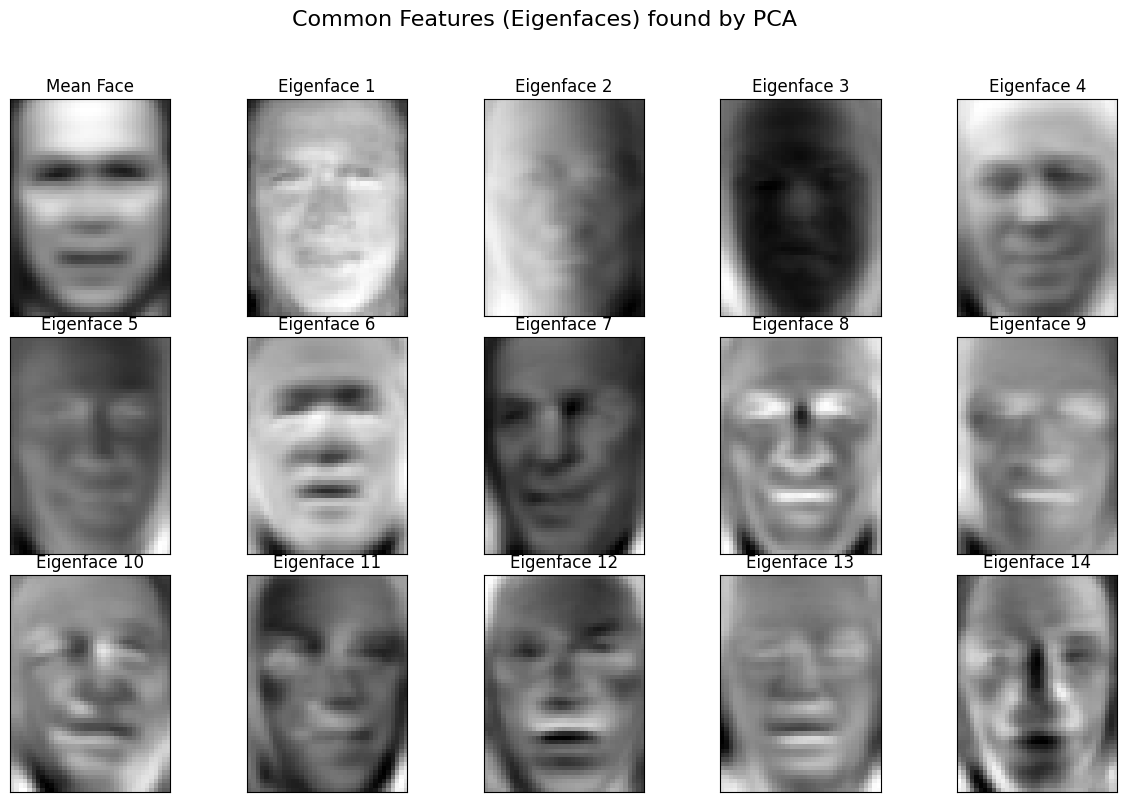

In [75]:

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4, color=False)


n_samples, h, w = lfw_people.images.shape
X = lfw_people.data 
n_features = X.shape[1]

print(f"Total samples (faces): {n_samples}")
print(f"Total features (pixels): {n_features}")
print(f"Image dimensions: {h}x{w}")


n_components = 150 

pca = PCA(n_components=n_components)
pca.fit(X)


mean_face = pca.mean.reshape(h, w)


eigenfaces = pca.components.T.reshape((n_components, h, w))


print("Visualizing the 'mean face' and the top eigenfaces...")

fig, axes = plt.subplots(3, 5, figsize=(15, 9),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))


ax = axes[0, 0]
ax.imshow(mean_face, cmap='gray')
ax.set_title("Mean Face")

for i, ax in enumerate(axes.flat[1:]):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f"Eigenface {i+1}")

plt.suptitle("Common Features (Eigenfaces) found by PCA", fontsize=16)
plt.show()

Original image (pixels): 1850
Compressed image (weights): 150


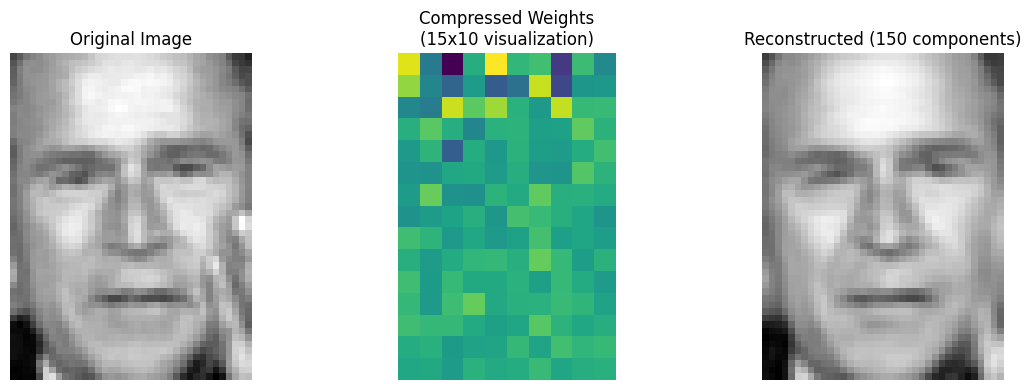

In [76]:
def scale_for_display(image):
    img_min = image.min()
    img_max = image.max()
    if img_max == img_min:
        return np.zeros_like(image)
    return (image - img_min) / (img_max - img_min)

test_index = 21 
test_image_flat = X[test_index]
test_image = test_image_flat.reshape(h, w)

compressed_weights = pca.transform(test_image_flat.reshape(1, -1))

print(f"Original image (pixels): {n_features}")
print(f"Compressed image (weights): {compressed_weights.shape[1]}")

reconstructed_image_flat = pca.inverse_transform(compressed_weights)
reconstructed_image = reconstructed_image_flat.reshape(h, w)

weights_2d = compressed_weights.squeeze().reshape(15, 10)
compressed_display = scale_for_display(weights_2d)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(test_image, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(compressed_display, cmap='viridis') 
ax[1].set_title(f"Compressed Weights\n(15x10 visualization)")
ax[1].axis('off')

ax[2].imshow(reconstructed_image, cmap='gray') 
ax[2].set_title(f"Reconstructed ({n_components} components)")
ax[2].axis('off')

plt.tight_layout()
plt.show()